In [4]:
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

In [5]:
yf.pdr_override()
y_symbols = ['601318.ss']
startdate = datetime(2020,1,1)
enddate = datetime(2020,3,20)
zgpa = dt.get_data_yahoo(y_symbols, start=startdate, end=enddate)
zgpa.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,85.900002,86.790001,85.879997,86.120003,72.726852,77825207
2020-01-03,86.809998,86.879997,85.900002,86.199997,72.794395,59498001
2020-01-06,85.919998,86.870003,85.500000,85.599998,72.287727,63644804
2020-01-07,86.010002,86.459999,85.669998,86.150002,72.752197,45218832
2020-01-08,85.000000,85.000000,85.000000,85.000000,71.781029,62805311


In [6]:
zgpa_signal = pd.DataFrame(index = zgpa.index)
zgpa_signal['price'] = zgpa['Adj Close']
zgpa_signal['diff'] = zgpa_signal['price'].diff()
zgpa_signal = zgpa_signal.fillna(0.0)
zgpa_signal['signal'] = np.where(zgpa_signal['diff'] >= 0, 0, 1)
zgpa_signal['order'] = zgpa_signal['signal'].diff()*100
zgpa_signal.head()

,price,diff,signal,order
Date,,,,
2020-01-02,72.726852,0.000000,0,NaN
2020-01-03,72.794395,0.067543,0,0.0
2020-01-06,72.287727,-0.506668,1,100.0
2020-01-07,72.752197,0.464470,0,-100.0
2020-01-08,71.781029,-0.971169,1,100.0


In [10]:
initial_cash = 20000.00
zgpa_signal['stock'] = zgpa_signal['order']*zgpa_signal['price']
zgpa_signal['cash'] = initial_cash - (zgpa_signal['order']*zgpa_signal['price']).cumsum()
zgpa_signal['total'] = zgpa_signal['order'].cumsum()*zgpa_signal['price'] + zgpa_signal['cash']

In [11]:
zgpa_signal.head()

,price,diff,signal,order,stock,cash,total
Date,,,,,,,
2020-01-02,72.726852,0.000000,0,NaN,NaN,NaN,NaN
2020-01-03,72.794395,0.067543,0,0.0,0.000000,20000.000000,20000.000000
2020-01-06,72.287727,-0.506668,1,100.0,7228.772736,12771.227264,20000.000000
2020-01-07,72.752197,0.464470,0,-100.0,-7275.219727,20046.446991,20046.446991
2020-01-08,71.781029,-0.971169,1,100.0,7178.102875,12868.344116,20046.446991


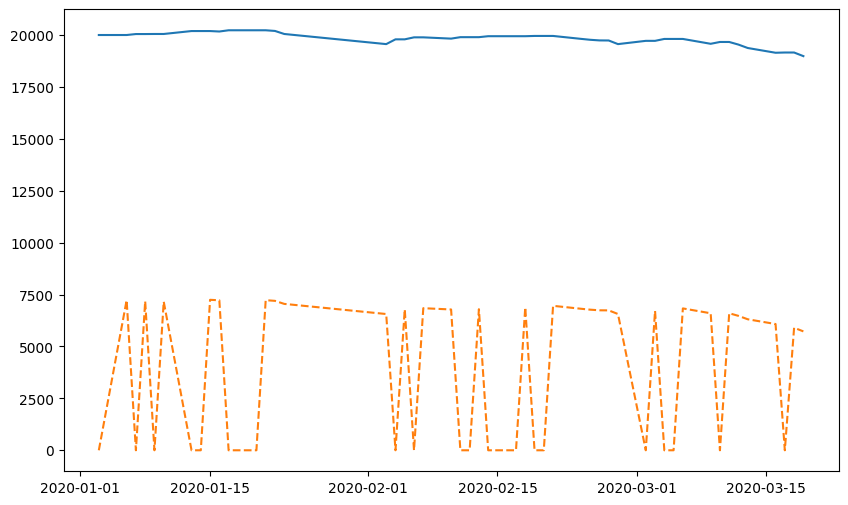

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(zgpa_signal['total'])
plt.plot(zgpa_signal['order'].cumsum()*zgpa_signal['price'], '--', label='stock value')

In [14]:
period = 10
avg_10 = []
avg_value = []
for price in zgpa['Adj Close']:
    avg_10.append(price)
    if len(avg_10) > period:
        del avg_10[0]
    avg_value.append(np.mean(avg_10))
zgpa = zgpa.assign(avg_10 = pd.Series(avg_value, index = zgpa.index))
zgpa.head()

,Open,High,Low,Close,Adj Close,Volume,avg_10
Date,,,,,,,
2020-01-02,85.900002,86.790001,85.879997,86.120003,72.726852,77825207,72.726852
2020-01-03,86.809998,86.879997,85.900002,86.199997,72.794395,59498001,72.760624
2020-01-06,85.919998,86.870003,85.500000,85.599998,72.287727,63644804,72.602992
2020-01-07,86.010002,86.459999,85.669998,86.150002,72.752197,45218832,72.640293
2020-01-08,85.000000,85.000000,85.000000,85.000000,71.781029,62805311,72.468440


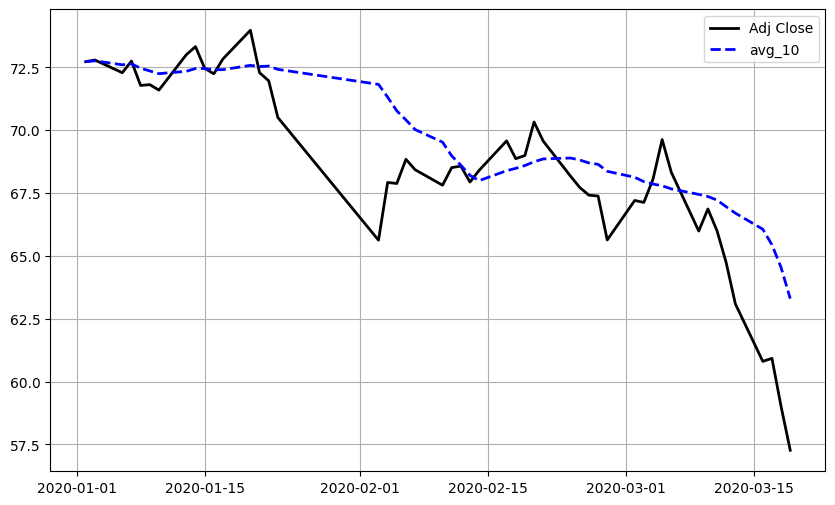

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(zgpa['Adj Close'], lw=2, c='k', label='Adj Close')
plt.plot(zgpa['avg_10'], '--', lw=2, c='b', label='avg_10')
plt.legend()
plt.grid()
plt.show()

In [16]:
strategy = pd.DataFrame(index = zgpa.index)
strategy['signal'] = 0
strategy['avg_5'] = zgpa['Adj Close'].rolling(5).mean()
strategy['avg_10'] = zgpa['Adj Close'].rolling(10).mean()
strategy['signal'] = np.where(strategy['avg_5'] > strategy['avg_10'], 1, 0)
strategy['order'] = strategy['signal'].diff()
strategy.tail(10)

,signal,avg_5,avg_10,order
Date,,,,
2020-03-06,1,68.066995,67.665022,1.0
2020-03-09,1,67.823784,67.447146,0.0
2020-03-10,1,67.771428,67.361854,0.0
2020-03-11,1,67.361008,67.219981,0.0
2020-03-12,0,66.381410,66.954813,-1.0
2020-03-13,0,65.334253,66.700624,0.0
2020-03-16,0,64.297228,66.060506,0.0
2020-03-17,0,63.108195,65.439812,0.0
2020-03-18,0,61.709734,64.535371,0.0


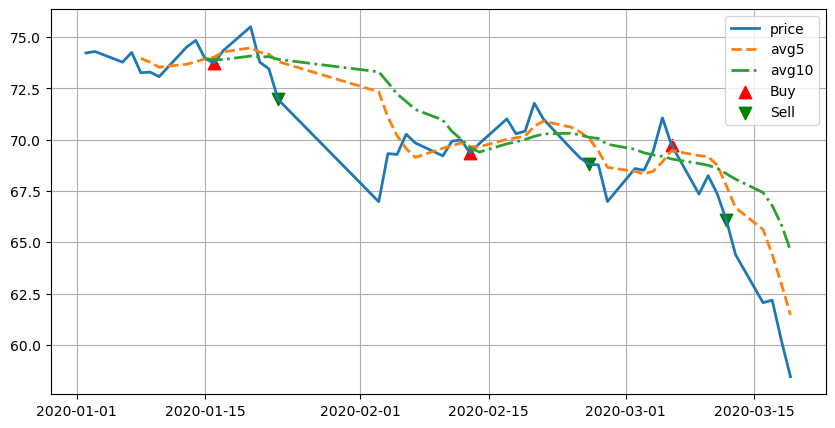

In [17]:
plt.figure(figsize=(10,5))
plt.plot(zgpa['Adj Close'], lw=2, label='price')
plt.plot(strategy['avg_5'], lw=2,ls='--', label='avg5')
plt.plot(strategy['avg_10'], lw=2,ls='-.', label='avg10')
plt.scatter(strategy.loc[strategy.order==1].index, zgpa['Adj Close'][strategy.order==1], marker='^', s=80, c='r', label='Buy')
plt.scatter(strategy.loc[strategy.order==-1].index, zgpa['Adj Close'][strategy.order==-1], marker='v', s=80, c='g', label='Sell')
plt.legend()
plt.grid()
plt.show()

In [18]:
initial_cash = 20000
positions = pd.DataFrame(index = strategy.index).fillna(0)
positions['stock'] = strategy['signal'] * 100
portfolio['stock value'] = positions.multiply(zgpa['Adj Close'], axis=0)
order = positions.diff()
portfolio['cash'] = initial_cash - order.multiply(zgpa['Adj Close'], axis=0).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['stock value']
portfolio.tail(10)

,stock value,cash,total
Date,,,
2020-03-06,6973.387909,12795.630646,19769.018555
2020-03-09,6734.649658,12795.630646,19530.280304
2020-03-10,6824.284363,12795.630646,19619.915009
2020-03-11,6735.512543,12795.630646,19531.143188
2020-03-12,0.000000,19401.862335,19401.862335
2020-03-13,0.000000,19401.862335,19401.862335
2020-03-16,0.000000,19401.862335,19401.862335
2020-03-17,0.000000,19401.862335,19401.862335
2020-03-18,0.000000,19401.862335,19401.862335


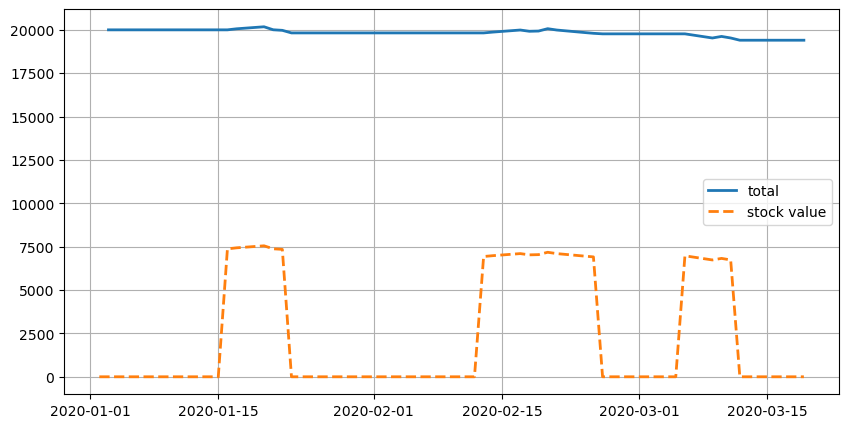

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(portfolio['total'], lw=2, label='total')
plt.plot(portfolio['stock value'], lw=2, ls='--', label='stock value')
plt.legend()
plt.grid()
plt.show()

In [32]:
turtle = pd.DataFrame(index = zgpa.index)
turtle['Adj Close']=zgpa['Adj Close']
turtle['high'] = zgpa['Adj Close'].shift(1).rolling(5).max()
turtle['low'] = zgpa['Adj Close'].shift(1).rolling(5).min()
turtle['buy'] = zgpa['Adj Close'] > turtle['high']
turtle['sell'] = zgpa['Adj Close'] < turtle['low']
turtle.tail()

,Adj Close,high,low,buy,sell
Date,,,,,
2020-03-13,64.390282,69.733879,66.062317,False,True
2020-03-16,62.054611,68.242844,64.390282,False,True
2020-03-17,62.175270,68.242844,62.054611,False,False
2020-03-18,60.218845,67.355125,62.054611,False,True
2020-03-19,58.443382,66.062317,60.218845,False,True


In [33]:
turtle['orders'] = 0
position = 0
for k in range(len(turtle)):
    if turtle.buy[k] and position ==0:
        turtle.orders.values[k] = 1
        position = 1
    elif turtle.sell[k] and position > 0:
        turtle.orders.values[k] = -1
        position = 0
turtle.tail(15)

,Adj Close,high,low,buy,sell,orders
Date,,,,,,
2020-02-28,66.984512,71.000816,68.768585,False,True,0
2020-03-02,68.587593,69.570129,66.984512,False,False,0
2020-03-03,68.510025,69.113327,66.984512,False,False,0
2020-03-04,69.449455,68.803062,66.984512,True,False,1
2020-03-05,71.061157,69.449455,66.984512,True,False,0
2020-03-06,69.733879,71.061157,66.984512,False,False,0
2020-03-09,67.346497,71.061157,68.510025,False,True,-1
2020-03-10,68.242844,71.061157,67.346497,False,False,0
2020-03-11,67.355125,71.061157,67.346497,False,False,0


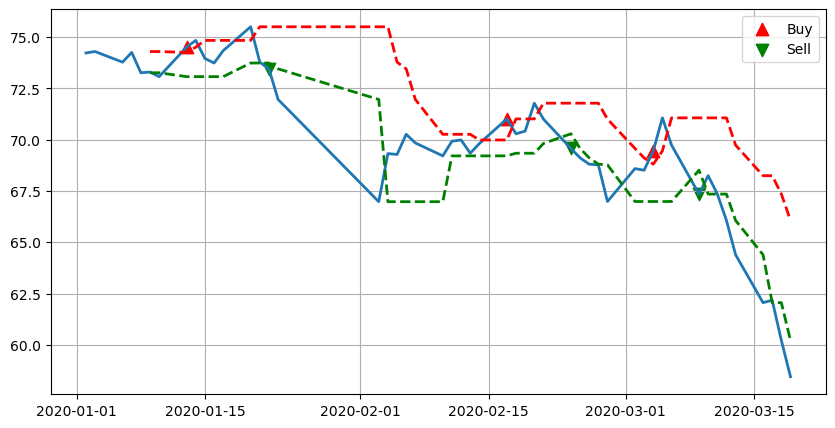

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(zgpa['Adj Close'], lw=2)
plt.plot(turtle['high'], lw=2, ls ='--', c='r')
plt.plot(turtle['low'], lw=2, ls='--',c='g')
plt.scatter(turtle.loc[turtle.orders==1].index,
            zgpa['Adj Close'][turtle.orders==1],
            marker='^',s=80,color='r', label='Buy')
plt.scatter(turtle.loc[turtle.orders==-1].index,
            zgpa['Adj Close'][turtle.orders==-1],
            marker='v',s=80,color='g', label='Sell')
plt.legend()
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


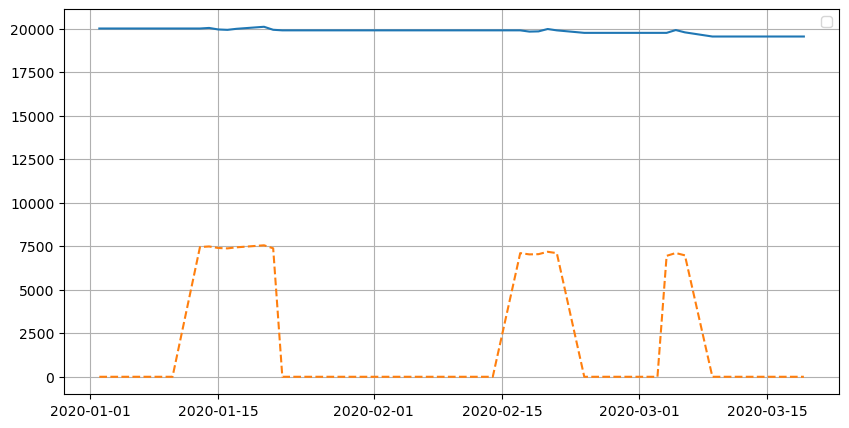

In [51]:
initial_cash = 20000
positions = pd.DataFrame(index = strategy.index).fillna(0)
positions['stock'] = 100 * turtle['orders'].cumsum()
portfolio = positions.multiply(zgpa['Adj Close'], axis=0)
portfolio['holding_values'] = positions.multiply(zgpa['Adj Close'], axis=0)
pos_diff = pd.DataFrame(turtle, columns=['orders'])
pos_diff['orders'] *= 100
portfolio['cash']=initial_cash - (pos_diff.multiply(zgpa['Adj Close'], axis=0)).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holding_values']
plt.figure(figsize=(10,5))
plt.plot(portfolio['total'])
plt.plot(portfolio['holding_values'], '--')
plt.grid()
plt.legend()
plt.show()



In [52]:
portfolio.tail(13)

,stock,holding_values,cash,total
Date,,,,
2020-03-03,0.000000,0.000000,19750.058746,19750.058746
2020-03-04,6944.945526,6944.945526,12805.113220,19750.058746
2020-03-05,7106.115723,7106.115723,12805.113220,19911.228943
2020-03-06,6973.387909,6973.387909,12805.113220,19778.501129
2020-03-09,0.000000,0.000000,19539.762878,19539.762878
2020-03-10,0.000000,0.000000,19539.762878,19539.762878
2020-03-11,0.000000,0.000000,19539.762878,19539.762878
2020-03-12,0.000000,0.000000,19539.762878,19539.762878
2020-03-13,0.000000,0.000000,19539.762878,19539.762878
